In [1]:
from scipy import special
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
def prob_dist(alpha, beta, theta):
#     f = special.gamma(alpha + beta) / (special.gamma(alpha) * special.gamma(beta)) * theta ** (alpha - 1) * (1 - theta) ** (beta - 1)
    log_f = np.log(special.gamma(alpha + beta)) - np.log(special.gamma(alpha)) - np.log(special.gamma(beta)) \
            + (alpha - 1) * np.log(theta) + (beta - 1) * np.log(1 - theta)
    return np.exp(log_f)
    

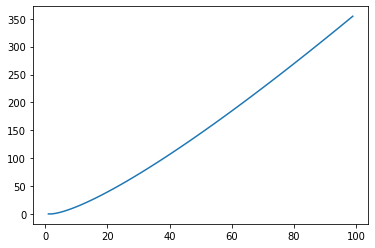

In [16]:
x = np.arange(1,100)
plt.plot(x, np.log( special.gamma(x)) )

# Plot probability distribution

Text(0, 0.5, 'Certainty of win-probability')

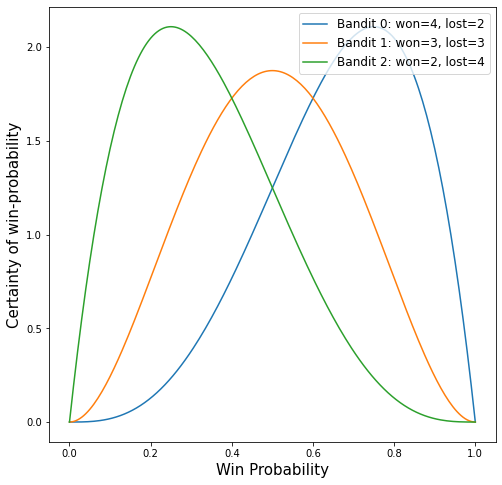

In [3]:
x = np.linspace(0, 1, 201)

plt.figure(figsize=(8,8))
for i, (alpha, beta) in enumerate ([(4, 2), (3, 3), (2, 4)]):
    plt.plot(x, p(alpha, beta, x), label="Bandit {}: won={}, lost={}".format(i, alpha, beta))
plt.legend(loc="upper right", fontsize=12)
plt.xlabel("Win Probability", fontsize=15)
plt.ylabel("Certainty of win-probability", fontsize=15)

# Compare exploration algorithm

## Greedy algorithm

In [114]:
NUM_TRIAL = 1000
NUM_STEPS = 100
thetas = [0.9, 0.8, 0.7]


avg_action_probability_history = np.zeros((NUM_STEPS, 3))

for run_idx in range(NUM_TRIAL):

    action_probability_history = np.zeros((NUM_STEPS, 3))
    alphas = [1, 1, 1]
    betas  = [1, 1, 1]
    
    for step in range(NUM_STEPS):
        theta_estimates = np.zeros(3)
        for i in range(3):
            theta_estimates[i] = alphas[i] / (alphas[i] + betas[i])

        action_probability = np.zeros(3)
        chosen_bandits = []
        for idx, item in enumerate(theta_estimates):
            if item == max(theta_estimates):
                chosen_bandits.append(idx)
                action_probability[idx] = 1
        
        action_probability = action_probability / np.sum(action_probability)
        action_probability_history[step, :] = action_probability

        chosen_bandit = chosen_bandits[np.random.choice(len(chosen_bandits)) - 1]

        # random sampling
        r = np.random.random()
        if r < thetas[chosen_bandit]:
            alphas[chosen_bandit] += 1
        else:
            betas[chosen_bandit] += 1 

    action_probability_history = np.array(action_probability_history)
    
    avg_action_probability_history = (run_idx * avg_action_probability_history + action_probability_history) \
        / (1 + run_idx)

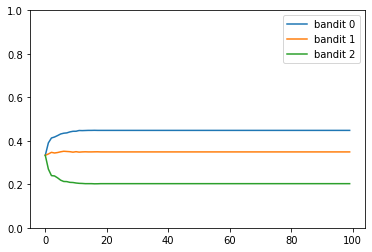

In [115]:
plt.figure()
for i in range(3):
    plt.plot(avg_action_probability_history[:,i], label="bandit {}".format(i))
plt.ylim((0,1))
plt.legend()
plt.show()

## Thomson sampling

In [25]:
NUM_TRIAL = 1000
NUM_STEPS = 100
thetas = [0.9, 0.8, 0.7]

avg_action_probability_history = np.zeros((NUM_STEPS, 3))

for run_idx in range(NUM_TRIAL):

    action_probability_history = np.zeros((NUM_STEPS, 3))
    alphas = [1, 1, 1]
    betas  = [1, 1, 1]
    
    for step in range(NUM_STEPS):
        theta_estimates = np.zeros(3)
        for i in range(3):
            theta_hat = np.linspace(1e-2, 1 - 1e-2, 100)
            ps = prob_dist(alphas[i], betas[i], theta_hat)
            theta_estimates[i] = np.random.choice(theta_hat, p=ps/np.sum(ps))

        action_probability = np.zeros(3)
        chosen_bandits = []
        for idx, item in enumerate(theta_estimates):
            if item == max(theta_estimates):
                chosen_bandits.append(idx)
                action_probability[idx] = 1
        
        action_probability = action_probability / np.sum(action_probability)
        action_probability_history[step, :] = action_probability

        chosen_bandit = chosen_bandits[np.random.choice(len(chosen_bandits)) - 1]

        # random sampling
        r = np.random.random()
        if r < thetas[chosen_bandit]:
            alphas[chosen_bandit] += 1
        else:
            betas[chosen_bandit] += 1 

    action_probability_history = np.array(action_probability_history)
    
    avg_action_probability_history = (run_idx * avg_action_probability_history + action_probability_history) \
        / (1 + run_idx)

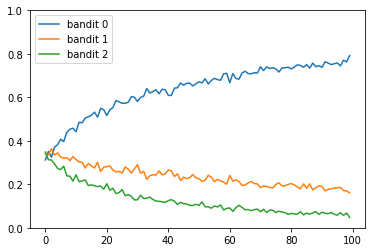

In [26]:
plt.figure()
for i in range(3):
    plt.plot(avg_action_probability_history[:,i], label="bandit {}".format(i))
plt.ylim((0,1))
plt.legend()
plt.show()